<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar bibliotecas

In [1]:
!pip install contractions

In [2]:
import pandas as pd
import numpy as np
import contractions
import re

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

## Descomprimir archivo

In [3]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/MyDrive/Datos/ReviewsAmazon.csv.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Datos/AmazonReviews')

# Leer datos de entrada

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=100000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(88563, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 12209
I finally found my hot sauce!!
Heard about this hot sauce on the Larry Miller podcast. Ordered up a couple bottles and my first test was on a pulled chicken bbq sandwich. I knew after one bite that the bottles of tabasco, chilula, etc...are gonna be gathering dust. Seriously. Great flavor and perfect heat. Thanks Dexter.

Review # 59432
My six year old likes them
I thought they were overly salty myself, but he said he could handle it. The pepper was less intrusive but it may well have been that the salt settles during shipping or handling and one cannister may be different than another. Not sure that I would purchase on a consistent basis but they were all eaten in my hosehold.

Review # 52014
The best!
I love this chocolate! for my sister and me this is the best chocolate in the world! The bad thing: it`s very hard to find it.

Review # 33844
Yummmmmmmmmmm!
These are fabulous. Too bad they don't come with tape to secure them directly to my hips :)<br /><br />They arriv

In [6]:
df.to_csv('Amazon_reviews_trim.csv', index=False)

# Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [7]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [8]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)
  
df.loc[738,'Text']

CPU times: user 6.04 s, sys: 21.7 ms, total: 6.06 s
Wall time: 6.08 s


In [9]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [10]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 11983
tokenstart you either love it or hate it apparently tokenend
i agree this is not extremely cheesy but that is what i like about it i have been using this for years and only one store near me carried it i have recently moved to florida and can not find it anywhere i do not understand the reviews that says it is too salty i tried the very overrated flavacol and found that to be way too salty i actually use more of this on my popcorn than i would think because it is not that salty it sticks to the popcorn better than salt and has a very good flavor admittedly not overly cheesy best popcorn seasoning i have ever tasted 

Review # 26444
tokenstart stash chamomile tea tokenend
stash chamomile herbal tea is tea bags with dried crushed chamomile flowers honestly as far as i am concerned chamomile is chamomile i suppose that when you use loose flowers you get sediment in the cup and i have seen this happen with some brands of chamomile tea bags these do not do that i have also h

# Limitar la cantidad de palabras en textos y resumenes

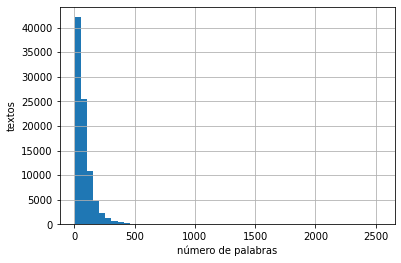


El 90% de los textos tiene 168 palabras


In [11]:
# ¿Cuantas palabras tienen cada texto?
palabras_textos = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_textos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_textos.quantile(0.90)))

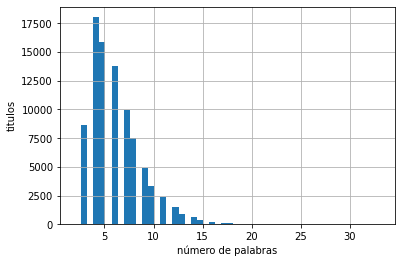


El 97.5% de los titulos tiene 13 palabras


In [12]:
# ¿Cuantas palabras tienen cada titulo?
palabras_titulos = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_titulos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("titulos")
plt.show()

print('\nEl 97.5% de los titulos tiene {:,.0f} palabras'.format(palabras_titulos.quantile(0.975)))

In [13]:
longitud_max_textos = palabras_textos.quantile(0.90)     #168 palabras
longitud_max_titulos = palabras_titulos.quantile(0.975)  # 13 palabras

In [14]:
datos =  df[(palabras_textos <= longitud_max_textos ) | (palabras_titulos <= longitud_max_titulos)]
datos.shape   

(87978, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)

# Vectorización del texto

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  
from tensorflow.data import Dataset

### Paso 1 Diccionario de vocabulario con clave y vectorizador de textos

In [17]:
def genera_dic_vocabulario(serie_pd, max_tokens= 20000):
  '''Obtiene el vocabulario de una serie de pandas con textos en forma de 
  diccionario, donde cada palabra es una clave y el valor es un indice'''
  vectorizer = TextVectorization(max_tokens = max_tokens  )  
  text_ds = Dataset.from_tensor_slices(serie_pd).batch( 128)  
  vectorizer.adapt(text_ds)   #similar a fit 
  voc = vectorizer.get_vocabulary()  # lista con el vocabulario
  #diccionario con el vocabulario
  dic_vocabulario = dict(zip(voc, range(len(voc))))
  return dic_vocabulario, vectorizer

In [18]:
%%time
vocabulario_dic, vectorizer_reseña = genera_dic_vocabulario(x_train)

CPU times: user 3.42 s, sys: 339 ms, total: 3.75 s
Wall time: 3.63 s


In [19]:
ejemplos = ['got', 'wild', 'hair', 'ordered', 'pound', 'bag']
[vocabulario_dic[palabra] for palabra in ejemplos]

[148, 1081, 502, 197, 614, 111]

In [20]:
vectorizer_reseña(ejemplos)

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[ 148],
       [1081],
       [ 502],
       [ 197],
       [ 614],
       [ 111]])>

In [21]:
vocabulario_dic.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'of', 'this', 'not', 'for', 'in', 'that', 'my', 'have', 'but', 'you', 'are', 'with', 'was', 'they', 'as', 'on', 'like', 'so', 'these', 'them', 'good', 'be', 'will', 'can', 'or', 'at', 'taste', 'just', 'one', 'do', 'if', 'product', 'would', 'very', 'great', 'all', 'flavor', 'am', 'from', 'coffee', 'we', 'when', 'more', 'has', 'tea', 'had', 'me', 'love', 'food', 'than', 's', 'out', 'no', 'other', 'get', 'amazon', 'some', 'up', 'really', 'about', 'only', 'too', 'much', 'an', 'there', 'because', 'your', 'were', 'also', 'time', 'little', 'did', 'use', 'what', 'he', 'buy', 'which', 'price', 'dog', 'she', 'tried', 'best', 'does', 'well', 'by', 'make', 'been', 'even', 'chocolate', 'find', 'better', 'try', 'after', 'eat', 'any', 'now', 'first', '2', 'sugar', 'drink', 'their', 'could', 'bag', 'our', 'cup', 'water', 'her', 'then', 'again', 'found', 'used', 'sweet', 'made', '1', 'box', 'think', 'bought', 'way', 'two', 'over', 'free'

In [22]:
len(vocabulario_dic)

20000

[UNK] se usa para cuando en nuevos ejemplos existan palabras que no se enciuentren en el diccionario.

### Paso 2 Diccionario con vectores de palabras (embeddings) [GloVe](https://nlp.stanford.edu/projects/glove/), previamente entrenados


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [23]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [24]:
%%time
dic_embeddings_GloVe  = {}
with open('/content/drive/MyDrive/Datos/Embeddings/glove.6B.100d.txt') as f:
    for line in f:
        palabra, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        dic_embeddings_GloVe [palabra] = coefs

#Cantidad de palabras en glove
len(dic_embeddings_GloVe )

CPU times: user 6.16 s, sys: 242 ms, total: 6.4 s
Wall time: 6.46 s


In [25]:
print(dic_embeddings_GloVe ["got"].shape)
dic_embeddings_GloVe ["got"]

(100,)


array([ 0.54635  ,  0.19018  ,  0.51298  , -0.76729  , -0.23824  ,
       -0.065802 ,  0.24464  ,  0.32024  , -0.13215  , -0.51083  ,
        0.69103  ,  0.24462  ,  0.075322 ,  0.34058  ,  0.37736  ,
       -0.27647  , -0.22937  ,  0.32059  , -0.43115  ,  0.37238  ,
        0.43887  ,  0.67325  ,  0.1064   , -0.28668  ,  0.16699  ,
        0.0035841, -0.6208   , -0.31726  ,  0.55472  , -0.47293  ,
       -0.072485 ,  1.1329   ,  0.45969  ,  0.59817  ,  0.43119  ,
       -0.11359  , -0.70584  ,  0.37556  ,  0.048478 ,  0.43989  ,
       -0.078231 , -0.3277   ,  0.37055  , -0.86839  , -0.22885  ,
       -0.049179 , -0.21562  , -0.049966 ,  0.82177  , -1.0077   ,
       -0.3538   , -0.12548  , -0.4025   ,  0.70979  , -0.24674  ,
       -2.4466   , -0.099338 ,  0.49705  ,  1.0912   ,  0.73681  ,
        0.26601  ,  1.0726   , -1.1285   ,  0.22433  ,  0.47524  ,
       -0.3435   ,  0.44802  ,  0.3436   , -0.29327  ,  0.34002  ,
       -0.061204 ,  0.12671  ,  0.049335 , -0.33836  ,  0.0145

### Paso 3 Obtener la matriz de vectores para todas las palabras del vocabulario 
embedding_texto()

In [26]:
def embedding_texto(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    num_tokens = len(dic_vocabulario.keys()) + 2  # se suman dos más para '' y '[UNK]'
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [27]:
embedding_matrix = embedding_texto(vocabulario_dic, dic_embeddings_GloVe , 100)

18376 palabras vectorizadas, que representan 91.9% de todas las palabras en el corpus


In [28]:
embedding_matrix.shape

(20002, 100)


**Repetiremos el paso 1 y el paso 3 para crear el diccionario de los Resumenes.(el diccionario con vectores GloVe es el mismo)**

In [29]:
vocabulario_dic_sum, vectorizer_sum = genera_dic_vocabulario(y_train)
embedding_matrix_sum = embedding_texto(vocabulario_dic_sum, dic_embeddings_GloVe , 100)
embedding_matrix_sum.shape

11445 palabras vectorizadas, que representan 80.2% de todas las palabras en el corpus


(14277, 100)

## Paso 4. Vectorizar conjunto de entrenamiento y pruba

In [30]:
datos.loc[5,'Text']

'i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat '

In [31]:
vectorizer_reseña(datos.loc[5,'Text'])

<tf.Tensor: shape=(73,), dtype=int64, numpy=
array([   3,  148,    5, 1081,  502,   12, 3097,    4,  197,   10,  706,
        614,  111,    2, 3097,   21,   44,   42, 1523,   20,  149,  156,
       2361, 1469, 1329, 6178, 1390, 1133,  462,   15,   69, 1075,    8,
         73,   21,    5,  132,   70,   71,  473,  328,  950,  383,  414,
         36,   11,   15,  798,  996,  578,   55,   15,  370,    4,   15,
        389,   10, 1808,   69,  127,  580,    3,   41,  145,   10,  168,
          9, 3097,    6,   21,    5, 1848,  204])>

In [32]:
x_train[0:10].apply(vectorizer_reseña)

55357    (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
64435    (tf.Tensor(12, shape=(), dtype=int64), tf.Tens...
78907    (tf.Tensor(348, shape=(), dtype=int64), tf.Ten...
84916    (tf.Tensor(4148, shape=(), dtype=int64), tf.Te...
23152    (tf.Tensor(27, shape=(), dtype=int64), tf.Tens...
19857    (tf.Tensor(44, shape=(), dtype=int64), tf.Tens...
12473    (tf.Tensor(15, shape=(), dtype=int64), tf.Tens...
58435    (tf.Tensor(10, shape=(), dtype=int64), tf.Tens...
26992    (tf.Tensor(10, shape=(), dtype=int64), tf.Tens...
5139     (tf.Tensor(7081, shape=(), dtype=int64), tf.Te...
Name: Text, dtype: object

In [33]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_sum)
y_test_vec = y_test.apply(vectorizer_sum)

CPU times: user 12min 57s, sys: 1min 27s, total: 14min 25s
Wall time: 12min 17s


In [34]:
len(y_train_vec)

79180

In [35]:
 #obtener indices de reseñas a eliminar
 indx =set()
 for i in y_train_vec.index:
   tot_unk = np.isin(y_train_vec[i], 1).sum()
   if tot_unk >= 1:
     indx.add (i)


In [36]:
len(indx)/len(y_train_vec)

0.0

Necesitamos homogeneisar las dimensiones de los tensores, para ello usamos la función pad_sequence 

In [37]:
%%time
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_textos), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_textos), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_titulos) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_titulos) , padding='post') 

CPU times: user 1min 8s, sys: 9.78 s, total: 1min 18s
Wall time: 1min 1s


In [38]:
x_train_vec.shape, y_train_vec.shape

((79180,), (79180,))

In [39]:
x_test_vec.shape, y_test_vec.shape

((8798,), (8798,))

# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del codificador y decodificador

Codificador 3 capas con 3 LTSM y 320 dimensiones latentes


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Concatenate, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K 


In [41]:
num_tokens_rev = len(vocabulario_dic) + 2
num_tokens_sum = len(vocabulario_dic_sum) + 2
embedding_dim = 100

In [42]:
K.clear_session() 
latent_dim = 320

# CODIFICADOR   ================================================================

encoder_inputs = Input(shape = (int(longitud_max_textos),))

enc_emb_lay = Embedding(num_tokens_rev, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_sum, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sum),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




##Attention Layer

Fuente: https://github.com/madhav727/abstractive-news-summary

In [43]:
!cp drive/MyDrive/Datos/attention.py .


In [44]:
from attention import AttentionLayer

In [45]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])  #concatena los estados ocultos del codificador y del decodificador para construir el vector de contexto

## Union del modelo

In [46]:
embedding_matrix_sum.shape

(14277, 100)

In [47]:
embedding_matrix_sum.shape[0]

14277

In [48]:
# Unión de la salida del decodificador(distribución del vocabulario probeniente de los resumenes
# y el vector de contexto delmódulo de atención en la capa con activación softmax

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(embedding_matrix_sum.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo definitivo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



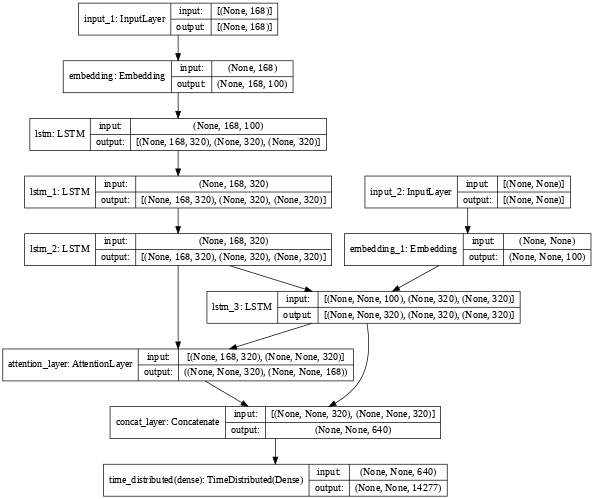

In [49]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 168, 100)     2000200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 168, 320), ( 538880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Entrenamiento del modelo

In [51]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [52]:
%%time

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 50, 

                    #terminar antes cuando no disminuya la función de pérdida
                    callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                                             verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/50
155/155 [==============================] - 150s 920ms/step - loss: 3.2780 - val_loss: 2.3347
Epoch 2/50
155/155 [==============================] - 151s 972ms/step - loss: 2.2672 - val_loss: 2.1904
Epoch 3/50
155/155 [==============================] - 156s 1s/step - loss: 2.1246 - val_loss: 2.0833
Epoch 4/50
155/155 [==============================] - 158s 1s/step - loss: 2.0103 - val_loss: 2.0112
Epoch 5/50
155/155 [==============================] - 158s 1s/step - loss: 1.9198 - val_loss: 1.9615
Epoch 6/50
155/155 [==============================] - 159s 1s/step - loss: 1.8568 - val_loss: 1.9079
Epoch 7/50
155/155 [==============================] - 159s 1s/step - loss: 1.7941 - val_loss: 1.8806
Epoch 8/50
155/155 [==============================] - 158s 1s/step - loss: 1.7471 - val_loss: 1.8495
Epoch 9/50
155/155 [==============================] - 159s 1s/step - loss: 1.7001 - val_loss: 1.8343
Epoch 10/50
155/155 [==============================] - 159s 1s/step - loss: 1.6463 - 

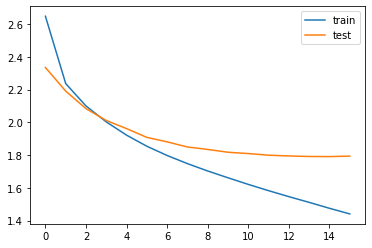

In [53]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [54]:
#Guardar todo el modelo
model.save('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM/assets


In [55]:
#modelo = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/rrn_modelo')

# Check its architecture
#modelo.summary()

#Invertir diccionario de vocabulario
El objetivo es que a partir de indice, regrese palabras

In [56]:
reversed_vocabulario_dic_sum = dict(map(reversed, vocabulario_dic_sum.items()))
reversed_vocabulario_dic_text = dict(map(reversed, vocabulario_dic.items()))


#Modelo de Inferencia y Generación de Texto

In [57]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_textos), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

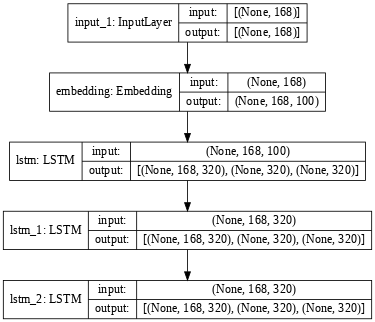

In [58]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

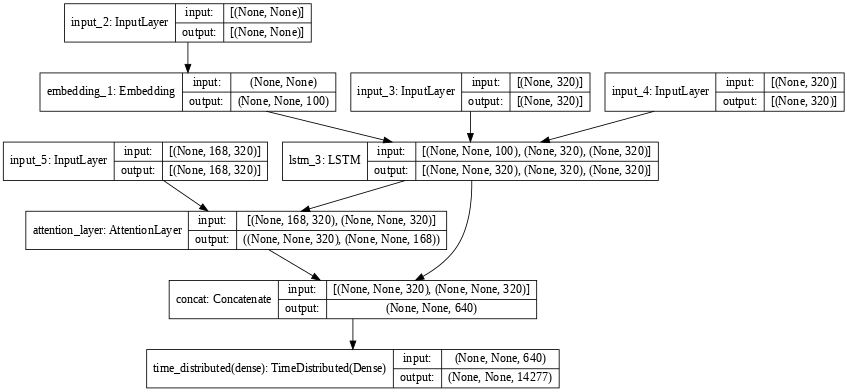

In [59]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante decode_sequence()

[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [60]:
reversed_vocabulario_dic_sum[0]

''

In [61]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  vocabulario_dic_sum['tokenstart']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Escoje la proxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reversed_vocabulario_dic_sum[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_titulos-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [62]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != vocabulario_dic_sum['tokenstart']) and i != vocabulario_dic_sum['tokenend']):
        newString = newString + reversed_vocabulario_dic_sum[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reversed_vocabulario_dic_text[i]+' '
    return newString

In [63]:
x_test_seq[1]
#.reshape(1, -1)

array([   10,    40,     3,   276,   145,    39,    75,    87,    52,
           5,   601, 10313,    74,     3,   125,    10,    12,    15,
          87,     4,    88,    52,     1,     4,   115, 10313,   412,
         126,   213,     4,     3,    32,   431,   115,   456,    99,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [64]:
x_test.iloc[0]

'there are many types of honey mustard pretzel but the snyder honey mustard pieces are the best most flavorful and satisfying to me others just do not compare and are lightly flavored in comparison i love them '

In [65]:
y_test.iloc[0]

'tokenstart honey mustard pretzels tokenend'

In [66]:
for i in range(0, 10):
  print(i)
  print("Review:",seq2text(x_test_seq[i]))
  print("Original summary:",seq2summary(y_test_seq[i]))
  print("Predicted summary:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

0
Review: there are many types of honey mustard pretzel but the snyder honey mustard pieces are the best most flavorful and satisfying to me others just do not compare and are lightly flavored in comparison i love them 
Original summary: honey mustard pretzels 
Predicted summary:  great for ginger


1
Review: this product i highly recommend if your dog has a huge swelling because i bought this for my dog and she has [UNK] and her swelling went way down and i can open her mouth better 
Original summary: this is a good product 
Predicted summary:  dog loves them


2
Review: i tried congo [UNK] in my friend s house and absolutely love it but since i prefer green tea i have ordered fiji it has great taste hope the quality of the tea also good love fiji and going to try some other flavor from [UNK] 
Original summary: great taste 
Predicted summary:  great tea


3
Review: i love this tea the full bodied flavor and aroma is smooth and relaxing order the two packs of one hundred the shipping i